# Fundamentos de bases de datos
## Laboratorio 2022 - Tarea 3

**Objetivos:** 

* Experimentar y analizar las consecuencias ocasionadas por problemas en el diseño de bases de datos relacionales.
* Poner en práctica las técnicas y algoritmos de diseño y normalización

En esta tarea vamos a partir de una porción de la realidad descripta en la tarea 1. Se presentará un primer diseño relacional que tiene problemas. Realizaremos consultas que mostrarán algunas de las consecuencias de esos problemas y por último se presentarán escenarios donde se deberá proponer un nuevo diseño que solucione los problemas que allí se encuentren.

**Referencias y material de consulta**

- Material del curso de Fundamentos de Bases de datos sobre diseño relacional
- [EN, 2016] Capítulos 14 y 15, Fundamentals of Database Systems, Elmasri & Navathe, 7th Edition, Pearson, 2016
- [Documentación de PostgreSQL sobre Triggers](https://www.postgresql.org/docs/14/triggers.html)


**Entrega:** Realizar todas las actividades que se describen en este notebook. Si es necesario, se pueden agregar más celdas tanto de tipo markdown como código. Se pide entregar:
1. el `notebook modificado` que refleje el trabajo realizado por el grupo, incluyendo respuestas, explicaciones y el código generado, y
2. el `pdf` correspondiente al notebook entregado

**IMPORTANTE:** 
1. Comprobar antes de realizar la entrega final, haber completado la primera sección "Datos del grupo"
2. Para las consultas SQL **no se podrán utilizar** subconsultas en el `FROM` ni en el `SELECT`. Tampoco `vistas` ni la cláusula `WITH`.

**PLAZO DE ENTREGA:** lunes 24/10/2022 23:59


# Datos del grupo

**Identificación del grupo:** bdatosNN
    
**Integrantes:**
* nombre apellido integrante i - cédula de identidad integrante i

## Descripción de la realidad 

Se trabajará con una parte de la realidad descripta en la tarea 1. Nos focalizaremos en las sagas y sus películas. Las calificaciones de las películas por parte de las personas suscriptas a las plataformas. Las personas que trabajan en los episodios de temporadas de las series. Contemplaremos un cambio pedido por nuestro cliente respecto a las calificaciones. Se permitirá que una persona suscripta en una plataforma pueda realizar más de una calificación a la misma pelicula pero sólo en fechas diferentes. Para ello se introduce la fecha de la calificación. 

A continuación, se presenta el Modelo Entidad-Relación de `miniMovies` representando a esta realidad, comenzando por el Diagrama de Entidad-Relación (DER):


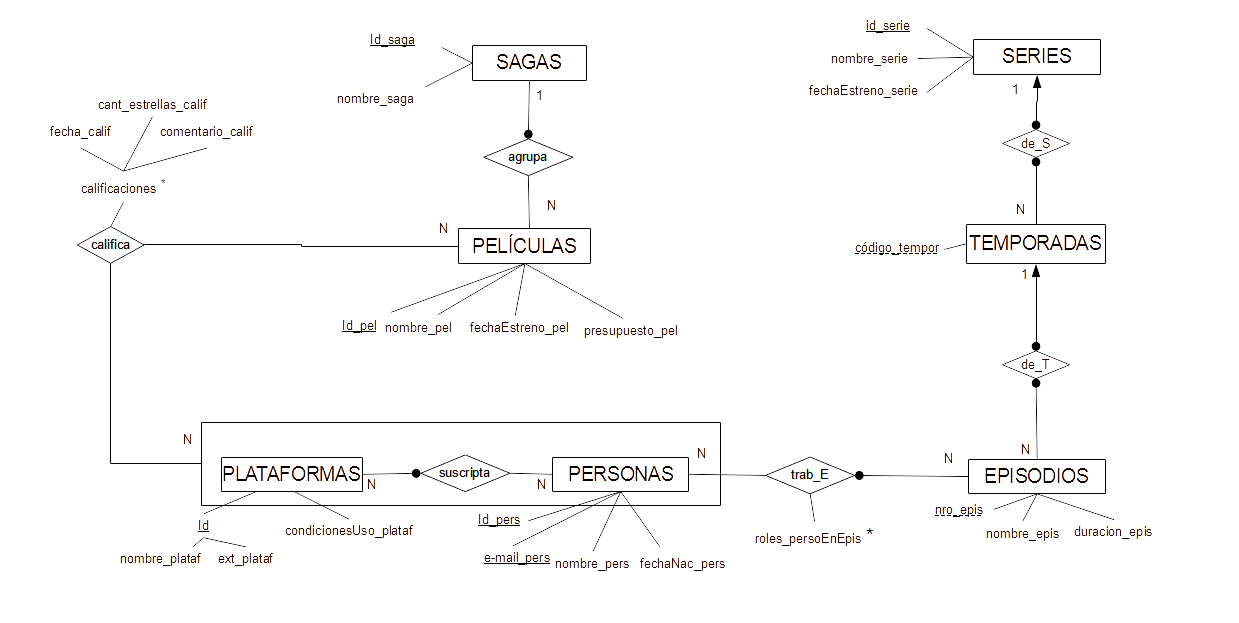


Se complementa el DER con las siguientes Restricciones No Estructurales (RNEs):

**RNE1:** Para todo episodio, su duración es mayor a 0.

$
(\forall e \in Episodios) (duracion(e) > 0)
$


**RNE2:** Para toda calificación, la cantidad de estrellas de la calificación es mayor o igual a 1 y menor o igual a 5, y la fecha de la calificación es mayor o igual a la fecha de la película.

$
(\forall pt \in Plataformas)(\forall p \in Personas)(\forall pl \in Peliculas) \\
    (<pt, p> \in suscripta \land <<pt, p>, pl> \in califica \\ 
        \rightarrow 
            (\forall c \in calificaciones(<<pt, p>, pl>)) 
                (cant\_estrellas\_calif(c) \geq 1 \land cant\_estrellas\_calif(c) \geq 5 \\
                \land fecha\_calif(c) \geq  fechaEstreno\_pel(pl)
                )                
     )
$

**RNE3:** Las calificaciones, de una persona suscripta a una plataforma a una misma película, no pueden tener 2 fechas de calificación iguales y que difieran en la cantidad de estrellas y/o en el comentario.

$
(\forall pt \in Plataformas)(\forall p \in Personas)(\forall pl \in Peliculas) \\
    (<pt, p> \in suscripta \land <<pt, p>, pl> \in califica \\ 
    \rightarrow 
       (
         (\forall c1 \in calificaciones(<<pt, p>, pl>))(\forall c2 \in calificaciones(<<pt, p>, pl>)) 
             (fecha\_calif(c1) = fecha\_calif(c2) \\
                \rightarrow cant\_estrellas\_calif(c1) = cant\_estrellas\_calif(c2) \land comentario\_calif(c1) = comentario\_calif(c2)
             )
       )
    )
$

## 1. Primer diseño de la base de datos miniMovies

A partir del relevamiento realizado, se generó un primer diseño relacional del esquema `miniMovies` que se presenta a continuación. <br>
**IMPORTANTE:** Notar que en este primer diseño, **no** se definieron claves primarias (_primary keys_) ni extranjeras o foráneas (_foreign keys_). 

    peliculas(
        id_pelicula,
        nombre_pelicula,
        fechaEstreno_pelicula,
        presupuesto_pelicula,
        id_saga,
        nombre_saga)

    calificaciones_peliculas(
        email_persona,
        nombre_plataf,
        ext_plataf,
        condicionesUso_plataf,
        nombre_pelicula,
        fecha_calif,
        cant_estrellas_calif,
        comentario_calif)

    personas_trabaja_episodios(
        id_persona,
        email_persona,
        nombre_persona,
        fechaNac_persona,
        nro_episodio,
        nombre_episodio,
        duracion_episodio,
        roles_personaEnEpisodio,
        codigo_temporada,
        id_serie,
        nombre_serie,
        fechaEstreno_serie)

### Actividad 1

Analice el diseño enfocado en identificar los problemas que presenta, en particular aquellos que provocan **anomalías de modificación** (ver Capítulo 14 de la referencia [EN, 2016] mencionada en la sección "Referencias y material de consulta" más arriba). 
Explique brevemente una anomalía en el caso de inserción, otra en el caso de borrado y otra en caso de modificación.

**Resultado actividad 1:** 




ANOMALIA DE INSERCION: Por ejemplo, tomamos la tabla de ejemplo de personas_tabaja_episodio, esta tabla tiene como atributo nombre_episodio, al insertar, podemos insertar una persona, la cual trabaje en un mismo episodio que otra, pero dicho episodio aparezca para una persona con un nombre, y para la otra con uno diferente.

ANOMALIA DE BORRADO: Similar al caso de la insercion, tenemos por ejemplo si se tiene que una sola persona trabaja en un episodio, este episodio apareceria solamente una vez y con esa persona. Por ende si se quiere borrar esta persona de la base de datos, estariamos perdiendo informacion de un episodio completo.

ANOMALIA DE MODIFICACION: Si se quiere modificar un dato, entonces debera ser consistente para todos los usos de ese dato. Supongamos que tenemos un episodio para el cual trabajan N personas, por ende en la tabla aparecera como minimo N veces (una vez por cada persona). Si se quiere modificar el nombre del episodio, por el motivo que sea, entonces se debera modificar para todas las ocurrencias de ese episodio. De no ocurrir lo anterior, tendremos un mismo episodio con algunas ocurrencias con un nombre, y otras ocurrencias con uno distinto.

# 2 Consultas exploratorias sobre una instancia de la base del primer diseño

En esta sección se propone la realización de algunas consultas para analizar dependencias funcionales en una instancia. Comenzaremos por crear y cargar la base.  


## 2.1 Creación y carga de la base de datos
Crear y poblar esta base de datos a partir de los scripts que están en el EVA del curso.


## 2.2 Consultas 


### Actividad 2: Dependencias funcionales

Se quiere escribir consultas para verificar si algunas dependencias funcionales se satisfacen para esta instancia. 

1. Considere verificar la DF: 
> id_pelicula $\rightarrow$ nombre_pelicula, fechaEstreno_pelicula, presupuesto_pelicula 
     1. Escriba una consulta sql simple (la proyección) que devuelva los datos de los atributos involucrados en la DF (_id_pelicula, nombre_pelicula, fechaEstreno_pelicula, presupuesto_pelicula_) y observar el resultado obtenido para verificar si se satisface la DF. 
     2. Escriba una consulta sql mejorada que permita verificar la DF sin tener que examinar exhaustivamente todos los datos como en el caso anterior. Suponga que esta consulta se va a utilizar sobre una tabla que tenga miles o millones de tuplas.

In [1]:
#Resultado Actividad 2 - Parte 1.A

In [ ]:
%%sql select *
        from peliculas p1, peliculas p2
        where p1.id_pelicula = p2.id_pelicula and (p1.nombre_pelicula <> p2.nombre_pelicula OR 
                                           p1.fechaestreno_pelicula <> p2.fechaestreno_pelicula or
                                           p1.presupuesto_pelicula <> p2.presupuesto_pelicula)

2. Verifique la DF siguiente usando su idea de la parte 1B aplicada a este caso.
> nro_episodio, codigo_temporada, id_serie $\rightarrow$ duracion_episodio <br>

Inspeccione lo necesario para comprobar el resultado obtenido y explique brevemente porqué es el resultado esperado.

In [1]:
FALSO

select p.nro_episodio, p.codigo_temporada, p.id_serie, p.duracion_episodio
from personas_trabaja_episodios p, personas_trabaja_episodios a
where p.nro_episodio = a.nro_episodio and p.codigo_temporada = a.codigo_temporada and p.id_serie = a.id_serie and p.duracion_episodio <> a.duracion_episodio

3. Verifique la DF siguiente usando su idea de la parte 1B aplicada a este caso. 
> nombre_plataf, ext_plataf $\rightarrow$ condicionesUso_plataf <br>

Inspeccione lo necesario para comprobar el resultado obtenido y explique brevemente porqué es el resultado esperado.

In [ ]:
FALSO 

select *
from calificaciones_peliculas p, calificaciones_peliculas a
where p.nombre_plataf = a.nombre_plataf and p.ext_plataf = a.ext_plataf and p.condicionesUso_plataf <> a.condicionesUso_plataf

## 3. Join sin pérdida, Preservación de dependencias, Formas normales

### Actividad 3.1

Escribir en la celda a continuación todas las dependencias funcionales (DF) que se cumplen en esta realidad, a partir del Modelo de Entidad-Relación. Evitar redundancia tanto de atributos como de dependencias funcionales.

**Resultado actividad 3.1:** 

{id_saga $\rightarrow$ nombre_saga; <br>
id_pel $\rightarrow$ nombre_pel, fechaEstreno_pel, presupuesto_pel; <br>
nombre_plataf, ext_plataf $\rightarrow$ condicionesUso_plataf; <br>
id_pers  $\rightarrow$ e-mail_pers, nombre_pers, fechaNac_pers; <br>
e\-mail_pers  $\rightarrow$ id_pers, nombre_pers, fechaNac_pers; <br>
id_serie, codigo_tempor, nro_epis $\rightarrow$ nombre_epis, duracion_epis; <br>
id_serie $\rightarrow$ nombre_serie, fechaEstreno_serie; <br>
id_pel, id_pers, nombre_plataf, ext_plataf, fecha_calif $\rightarrow$ cant_estrellas_calif, comentario_calif; <br>
id_pel $\rightarrow$ id_saga;}


### Actividad 3.2

Considere la siguiente descomposición del esquema `miniMovies` consistente en las 2 relaciones siguientes:

     R1(id_pelicula,
        nombre_pelicula,
        fechaEstreno_pelicula,
        presupuesto_pelicula,
        id_saga,
        nombre_saga,
        email_persona,
        nombre_plataf,
        ext_plataf,
        condicionesUso_plataf,
        fecha_calif,
        cant_estrellas_calif,
        comentario_calif)

     R2(id_persona,
        email_persona,
        nombre_persona,
        fechaNac_persona,
        nro_episodio,
        nombre_episodio,
        duracion_episodio,
        roles_personaEnEpisodio,
        codigo_temporada,
        id_serie,
        nombre_serie,
        fechaEstreno_serie)

1. Determine las dependencias funcionales de la Actividad 3.1 que se proyectan en cada una de las 2 relaciones R1 y R2. 
1. Verifique si la descomposición (R1, R2) cumple las propiedades de join sin pérdida (JSP) y preservación de dependencias.

**Resultado actividad 3.2.1:** 

R1: <br>
{id_saga $\rightarrow$ nombre_saga; <br>
id_pel $\rightarrow$ nombre_pel, fechaEstreno_pel, presupuesto_pel; <br>
nombre_plataf, ext_plataf $\rightarrow$ condicionesUso_plataf; <br>

R2: <br>
id_pers  $\rightarrow$ e-mail_pers, nombre_pers, fechaNac_pers; <br>
e\-mail_pers  $\rightarrow$ id_pers, nombre_pers, fechaNac_pers; <br>
id_serie, codigo_tempor, nro_epis $\rightarrow$ nombre_epis, duracion_epis; <br>
id_serie $\rightarrow$ nombre_serie, fechaEstreno_serie; <br>

No se cumple: <br>
id_pel, id_pers, nombre_plataf, ext_plataf, fecha_calif $\rightarrow$ cant_estrellas_calif, comentario_calif; <br>

**Resultado actividad 3.2.2:** 

### Actividad 3.3

Determine la forma normal en que se encuentra cada relación R1 y R2 de la actividad 3.2, y luego indique la forma normal en que se encuentra el esquema `miniMovies` consistente en las relaciones R1 y R2. 

**Resultado actividad 3.3:**

## 4. Diseño de la nueva base de datos miniMovies

### Actividad 4

1. Aplicando **sólo** algoritmos de normalización vistos en el curso, proponga un nuevo diseño para la base miniMovies que se encuentre en BCNF y que cumpla la propiedad de JSP. Verifique si preserva dependencias funcionales."
2. Implemente el diseño propuesto, incluyendo claves primarias, claves alternativas y dependencias de clave foránea.
2. Implemente, utilizando triggers, el control de la restricción no estructural 2, al momento de la inserción de calificaciones. En caso de que no se satisfaga se debe impedir la inserción emitiendo un mensaje explicando el motivo.
2. Provea scripts con sentencias SQL que permitan chequear el/los triggers implementados, en casos donde se cumpla y no se cumpla la restricción controlada.


**Resultado actividad 4:**

In [9]:

%%sql

CREATE TABLE public.sagas
(
    id_saga integer NOT NULL,
    nombre_saga text,
    PRIMARY KEY (id_saga)
);

ALTER TABLE IF EXISTS public.sagas
    OWNER to postgres;

CREATE TABLE public.series
(
    id_serie integer NOT NULL,
    nombre_serie text,
    fecha_estreno date,
    PRIMARY KEY (id_serie)
);

ALTER TABLE IF EXISTS public.series
    OWNER to postgres;
	
CREATE TABLE public.peliculas
(
    id_pelicula integer NOT NULL,
    nombre_pelicula text,
    fecha_estreno_pel date,
    presupueso_pelicula bigint,
    PRIMARY KEY (id_pelicula)
);

ALTER TABLE IF EXISTS public.peliculas
    OWNER to postgres;

CREATE TABLE public.peliculas_en_sagas
(
    id_pelicula integer NOT NULL,
    id_saga integer NOT NULL,
    PRIMARY KEY (id_pelicula),
    FOREIGN KEY (id_pelicula)
        REFERENCES public.peliculas (id_pelicula) MATCH SIMPLE
        ON UPDATE CASCADE
        ON DELETE CASCADE
        NOT VALID,
   	FOREIGN KEY (id_saga)
        REFERENCES public.sagas (id_saga) MATCH SIMPLE
        ON UPDATE CASCADE
        ON DELETE CASCADE
        NOT VALID
);

ALTER TABLE IF EXISTS public.peliculas_en_sagas
    OWNER to postgres;



CREATE TABLE public.personas
(
    id_persona integer NOT NULL,
    email text NOT NULL,
    nombre text,
    fecha_nacimiento date,
    CONSTRAINT id_persona PRIMARY KEY (id_persona),
    CONSTRAINT emails UNIQUE (email)
);

ALTER TABLE IF EXISTS public.personas
    OWNER to postgres;

CREATE TABLE public.episodios_serie
(
    id_serie integer NOT NULL,
    codigo_temporada integer NOT NULL,
    nro_episodio integer NOT NULL,
    nombre_episodio text,
    duracion_episodio integer,
    PRIMARY KEY (id_serie, codigo_temporada, nro_episodio),
    CONSTRAINT series FOREIGN KEY (id_serie)
        REFERENCES public.series (id_serie) MATCH SIMPLE
        ON UPDATE CASCADE
        ON DELETE CASCADE
        NOT VALID
);

ALTER TABLE IF EXISTS public.episodios_serie
    OWNER to postgres;


CREATE TABLE public.cond_uso_plataforma
(
    nombre_plataf text,
    ext_plataf text,
    condUso_plataf text,
    PRIMARY KEY (ext_plataf, nombre_plataf)
);

ALTER TABLE IF EXISTS public.cond_uso_plataforma
    OWNER to postgres;

CREATE TABLE public.calificaciones_en_plataf
(
    id_pelicula integer,
    id_persona integer,
    nombre_plataf text,
    ext_plataf text,
    fecha_calif date,
    cant_estrellas integer,
    comentario text,
    PRIMARY KEY (id_pelicula, id_persona, nombre_plataf, ext_plataf, fecha_calif),
    FOREIGN KEY (id_persona)
        REFERENCES public.personas (id_persona) MATCH SIMPLE
        ON UPDATE CASCADE
        ON DELETE CASCADE
        NOT VALID,

   	FOREIGN KEY (nombre_plataf, ext_plataf)
        REFERENCES public.cond_uso_plataforma (nombre_plataf, ext_plataf) MATCH SIMPLE
        ON UPDATE CASCADE
        ON DELETE CASCADE
        NOT VALID,

    FOREIGN KEY (id_pelicula)
        REFERENCES public.peliculas (id_pelicula) MATCH SIMPLE
        ON UPDATE CASCADE
        ON DELETE CASCADE
        NOT VALID
);

ALTER TABLE IF EXISTS public.calificaciones_en_plataf
    OWNER to postgres;


CREATE TABLE public.restante_bcnf
(
    id_pelicula integer,
    id_persona integer,
    nombre_plataf text,
    ext_plataf text,
    fecha_calificacion date,
    id_serie integer,
    codigo_temporada integer,
    nro_episodio integer,
    roles_personaenepisodio text,
    FOREIGN KEY (id_persona)
        REFERENCES public.personas (id_persona) MATCH SIMPLE
        ON UPDATE CASCADE
        ON DELETE CASCADE
        NOT VALID,
    FOREIGN KEY (id_pelicula)
        REFERENCES public.peliculas (id_pelicula) MATCH SIMPLE
        ON UPDATE CASCADE
        ON DELETE CASCADE
        NOT VALID,
    FOREIGN KEY (id_serie)
        REFERENCES public.series (id_serie) MATCH SIMPLE
        ON UPDATE CASCADE
        ON DELETE CASCADE
        NOT VALID,
    FOREIGN KEY (nombre_plataf, ext_plataf)
        REFERENCES public.cond_uso_plataforma (nombre_plataf, ext_plataf) MATCH SIMPLE
        ON UPDATE CASCADE
        ON DELETE CASCADE
        NOT VALID,
    FOREIGN KEY (id_serie, codigo_temporada, nro_episodio)
        REFERENCES public.episodios_serie (id_serie, codigo_temporada, nro_episodio) MATCH SIMPLE
        ON UPDATE CASCADE
        ON DELETE CASCADE
        NOT VALID
);

ALTER TABLE IF EXISTS public.restante_bcnf
    OWNER to postgres;

In [10]:
#declaración de triggers y, si corresponde, funciones asociadas
%%sql

#EL TRIGGEN FUE CREADO UTILIZANDO PGADMIN POR LO QUE NO PODIA CREARLO UTILIZANDO SQL PURAMENTE Y 
#DE INTENTAR HACERLO USANDO SQL ME DEVOLVIA ERRORES.

CREATE FUNCTION RNE2() RETURNS trigger AS $RNE2$
    BEGIN
        IF NEW.cant_estrellas < 1 OR NEW.cant_estrellas > 5 THEN
            RAISE EXCEPTION 'No puede tener cantidad de estrellas menor a 1 ni mayor a 5';
        END IF;

        IF exists(SELECT 1
				 FROM peliculas p
				 WHERE NEW.fecha_calif < p.fecha_estreno_pel)
		THEN
            RAISE EXCEPTION 'La fecha de calificacion no puede ser menor a la fecha de estreno de la pelicula';
        END IF;
        RETURN NEW;
    END;
$RNE2$ LANGUAGE plpgsql;

CREATE TRIGGER RNE2 BEFORE INSERT ON calificaciones_en_plataf
    FOR EACH ROW EXECUTE FUNCTION RNE2();

    ####################

#ESTOS INSERTS SE PUEDEN CORRER TODOS JUNTOS SE UTILIZA SOLAMENTE LA PRIMER PELICULA
INSERT INTO peliculas
VALUES (1, 'pelisplus','01/10/2022', 1230);

INSERT INTO peliculas
VALUES (2, 'repeli','01/12/2008', 1230);
INSERT INTO peliculas
VALUES (3, 'monstruos','02/08/2015', 1230);
INSERT INTO personas
VALUES (1, 'mail@mail.com', 'juan', '02/10/2001');
INSERT INTO cond_uso_plataforma
VALUES ('netfli', '.uy', 'NO USAR');


#TESTEO DE FECHA MENOR A LA DE ESTRENO
INSERT INTO calificaciones_en_plataf
VALUES (1, 1, 'netfli', '.uy', '02/03/2009', 3, 'SIN COMENTARIOS');

#TESTEO DE ESTRELLAS < 1
INSERT INTO calificaciones_en_plataf
VALUES (1, 1, 'netfli', '.uy', '02/03/2024', 0, 'SIN COMENTARIOS');

#TESTEO DE ESTRELLAS > 5
INSERT INTO calificaciones_en_plataf
VALUES (1, 1, 'netfli', '.uy', '02/03/2024', 6, 'SIN COMENTARIOS');

#INSERTO EXITOSAMENTE
INSERT INTO calificaciones_en_plataf
VALUES (1, 1, 'netfli', '.uy', '02/03/2024', 4, 'SIN COMENTARIOS');